# 1. Import and Install Dependencies

## 1.1 Install Dependencies

<b>Windows 10/11</b> setup:
<br>

1) Download and install Python 3.10.11:
<br>
https://www.python.org/downloads/release/python-31011/
<br>
`"add python.exe to PATH"` during installation.
<br>
Restart Windows

2) Create Virtual environment:
<br>
Open terminal in the project folder.
<br>
`python -m venv venv`

3) Activate venv:
<br>
`venv\Scripts\activate`

4) Update pip:
<br>
`python -m pip install --upgrade pip`

5) Install dependencies:
<br>
`pip install tensorflow-gpu<2.11 matplotlib==3.7.* librosa scikit-learn pandas numpy ipykernel seaborn pyartnet sounddevice joblib`

6) Restart kernel (this notebook)


## 1.2 Training settings

Setup parameters for the machine learning system.
<br>See [model.md](./model.md) for more information about neural network architectures

In [1]:
# Audio parameters
AUDIO_CHUNK = 0.4  # seconds
SLICE_AUDIO = False
DATA_RANGE = 255  # 1 or 255
NUM_CHANNELS = 1  # Typically 1 for mono audio
SAMPLE_RATE = 44100  # Sample rate in Hz

# Audio Feature parameters:
MAIN_FEATURE = 'mel'  # 'mfcc' or 'mel' or 'stft'
N_MELS = 256  # Number of Mel bands
NFFT = 2048  # FFT window size for 'mel'
#NFFT = 512  # FFT window size for 'stft'
HOP_LENGTH = 256  # Number of samples between successive frames
N_MFCC = 40  # Number of MFCC coefficients
FMAX = SAMPLE_RATE // 2  # Maximum frequency, typically Nyquist frequency
N_FRAMES = round(SAMPLE_RATE * AUDIO_CHUNK / HOP_LENGTH) # Calculate number of frames

# ***  Input shape *** #
if MAIN_FEATURE == 'mfcc':
    INPUT_SHAPE = (N_FRAMES, N_MFCC, NUM_CHANNELS)
elif MAIN_FEATURE == 'mel':
    INPUT_SHAPE = (N_FRAMES, N_MELS, NUM_CHANNELS)
elif MAIN_FEATURE == 'stft':
    INPUT_SHAPE = (N_FRAMES, NFFT // 2 + 1, NUM_CHANNELS)

print('Input shape:', INPUT_SHAPE)
# Training settings
EPOCHS = 20
BATCH_SIZE = 8

# Model settings
MODEL_ARCH = "defaultCNN"
MODEL_TYPE = "default"
NEW_MODEL_NAME = 'test01'

Input shape: (69, 256, 1)


## 1.3 Load Dependencies

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
from classify_utilities import AudioProcessor
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import librosa
import numpy as np
import joblib
import random
from model import Deep_NN
from features import Audio_Features
from IPython.display import Audio, display


In [3]:
print(tf.config.list_physical_devices('GPU'))

[]


# 2. Preprocess the Data

- Put recorded dataset into "DATASET" folder.
- Recorded dataset shall be in format, where each audio class has its separate folder.
- Folders are named as wanted classification labels.

You can use "Dataset Recorder" tool to produce such dataset. 
<br>(https://github.com/Teapack1/Audio-Dataset-Recorder-Tools)

<br>example command to produce dataset:
<br>`python dr.py --classes wine_cling whiskey_cling --duration 0.5 --num_samples 100 --playback --treshold 0.25 --sample_rate 48000`

## 2.1 Define Paths to Files

In [4]:
DATASET_DIR = 'DATASET'
DATA_DIR = 'data'
TEST_DIR = 'TEST_DATA'
PLOTS_DIR = 'PLOTS'
METADATA = "metadata.csv"
MODEL_PATH = os.path.join("MODEL", f"model-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}")
LITE_MODEL_PATH = os.path.join("MODEL", f"model-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.tflite")
LABELER_PATH = os.path.join("MODEL", f"labeler-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.joblib")

# create folders if they don't exist
if not os.path.exists('MODEL'):
    os.makedirs('MODEL')
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('TEST_DATA'):
    os.makedirs('TEST_DATA')
if not os.path.exists('DATASET'):
    os.makedirs('DATASET')
if not os.path.exists('PLOTS'):
    os.makedirs('PLOTS')

In [5]:
dataset_files = os.listdir('dataset')
model_files = os.listdir('model')
test_files = os.listdir('TEST_DATA')

print("Files in 'DATASET' folder:")
print(dataset_files)

print("Files in 'MODEL' folder:")
print(model_files)

print("Files in 'TEST' folder:")
print(test_files)

Files in 'DATASET' folder:
['cheers', 'neg', 'silence']
Files in 'MODEL' folder:
['labeler-test01-defaultCNN-default-mel.joblib', 'labeler-test01-defaultCNN-default.joblib', 'labeler-test01-effnetv2_nn-default.joblib', 'labeler-test01-mobilenetv3_nn-small.joblib', 'labeler-test01-SmallerVGGNet-tiny.joblib', 'model-test01-defaultCNN-default', 'model-test01-defaultCNN-default-mel', 'model-test01-defaultCNN-default-mel.keras', 'model-test01-defaultCNN-default-mel.tflite', 'model-test01-defaultCNN-default.keras', 'model-test01-defaultCNN-default.tflite', 'model-test01-effnetv2_nn-default', 'model-test01-effnetv2_nn-default.keras', 'model-test01-effnetv2_nn-default.tflite', 'model-test01-mobilenetv3_nn-small', 'model-test01-mobilenetv3_nn-small.keras', 'model-test01-mobilenetv3_nn-small.tflite', 'model-test01-SmallerVGGNet-tiny', 'model-test01-SmallerVGGNet-tiny.keras', 'model-test01-SmallerVGGNet-tiny.tflite']
Files in 'TEST' folder:
['cheers', 'neg', 'silence']


In [6]:
audio_features = Audio_Features(sample_rate=SAMPLE_RATE, 
                                duration=AUDIO_CHUNK, 
                                n_mels=N_MELS, 
                                n_mfcc=N_MFCC, 
                                n_fft=NFFT, 
                                hop_length=HOP_LENGTH, 
                                data_range=DATA_RANGE,
                                use_delta=False,
                                use_standard_scaler=True
                                )

In [7]:
audio_processor = AudioProcessor(sample_rate=SAMPLE_RATE, 
                                 n_mels = N_MELS,
                                 fmax = FMAX,
                                 n_fft = NFFT,
                                 hop_length = HOP_LENGTH, 
                                 audio_chunk = AUDIO_CHUNK,
                                 slice_audio = SLICE_AUDIO,
                                 data_range=DATA_RANGE,
                                 features=audio_features,
                                 main_feature=MAIN_FEATURE)
                                 
                

## 2.2 Label Encoding

In [8]:
def encoder_fn(dataset_dir, labeler_dir, encoder, dump=False): 

    classes = os.listdir(dataset_dir)
    classes.sort()
    classes = np.array(classes).reshape(-1, 1)

    try:
        encoder.fit(classes)
    except IndexError:
        print("No classes found in dataset folder")
    if dump:
        joblib.dump(encoder, labeler_dir)

def idx2label(idx, encoder):
    idx_reshaped = np.array(idx).reshape(1, -1)
    return encoder.inverse_transform(idx_reshaped)[0][0]

def label2idx(label, encoder):
    label = np.array(label).reshape(-1, 1)
    return encoder.transform(label).toarray()[0]

In [9]:
oh_encoder = OneHotEncoder()

encoder_fn(dataset_dir=DATASET_DIR, labeler_dir=LABELER_PATH, encoder=oh_encoder)

In [10]:
random_label = random.choice(os.listdir(DATASET_DIR))
label2idx(random_label, oh_encoder)

array([1., 0., 0.])

In [11]:
idx2label(label2idx(random_label, oh_encoder), oh_encoder)

'cheers'

## 2.3 Exploratory data analysis

### Produce metadata dataframe

In [12]:
# Analyze dataset:
# List all the files in dictionare and subdictionaries.
metadata = []

for root, _, files in os.walk(DATASET_DIR):
    for i, file in enumerate(files):
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            label = os.path.basename(root)
            class_ = label2idx(label, oh_encoder)
            num_channels, sample_rate, bit_depth, avg_rms, length_in_seconds, length_in_frames = audio_processor.read_file_properties(filename)
            metadata.append({
                'filename': filename, 
                'label': label, 
                'class': class_,
                'num_channels': num_channels, 
                'sample_rate': sample_rate, 
                'bit_depth': bit_depth, 
                'avg_rms': avg_rms, 
                'length_in_seconds': length_in_seconds, 
                'length_in_frames': length_in_frames
            })

            print(f"Processing label: {label}, {i}th file named: {file}")
        else:
            print(f"Skipped {i} file. {file}")
            
metadata = pd.DataFrame(metadata)
metadata.to_csv(METADATA, index=False)

Processing label: cheers, 0th file named: cheersACwJuray18_0001.wav
Processing label: cheers, 1th file named: cheersACwJuray18_0002.wav
Processing label: cheers, 2th file named: cheersACwJuray18_0003.wav
Processing label: cheers, 3th file named: cheersACwJuray18_0004.wav
Processing label: cheers, 4th file named: cheersACwJuray18_0005.wav
Processing label: cheers, 5th file named: cheersACwJuray18_0006.wav
Processing label: cheers, 6th file named: cheersACwJuray18_0007.wav
Processing label: cheers, 7th file named: cheersACwJuray18_0008.wav
Processing label: cheers, 8th file named: cheersACwJuray18_0009.wav
Processing label: cheers, 9th file named: cheersACwJuray18_0010.wav
Processing label: cheers, 10th file named: cheersACwJuray18_0011.wav
Processing label: cheers, 11th file named: cheersACwJuray18_0012.wav
Processing label: cheers, 12th file named: cheersACwJuray18_0013.wav
Processing label: cheers, 13th file named: cheersACwJuray18_0014.wav
Processing label: cheers, 14th file named: c

### Observe the data

In [13]:
metadata.head()

filename   label            class  \
0  DATASET\cheers\cheersACwJuray18_0001.wav  cheers  [1.0, 0.0, 0.0]   
1  DATASET\cheers\cheersACwJuray18_0002.wav  cheers  [1.0, 0.0, 0.0]   
2  DATASET\cheers\cheersACwJuray18_0003.wav  cheers  [1.0, 0.0, 0.0]   
3  DATASET\cheers\cheersACwJuray18_0004.wav  cheers  [1.0, 0.0, 0.0]   
4  DATASET\cheers\cheersACwJuray18_0005.wav  cheers  [1.0, 0.0, 0.0]   

   num_channels  sample_rate  bit_depth   avg_rms  length_in_seconds  \
0             1        44100         16  0.024894           0.397982   
1             1        44100         16  0.011941           0.397982   
2             1        44100         16  0.010465           0.397982   
3             1        44100         16  0.006512           0.397982   
4             1        44100         16  0.006778           0.397982   

   length_in_frames  
0             17551  
1             17551  
2             17551  
3             17551  
4             17551

### class balance

In [14]:
print(metadata["label"].value_counts())

label
cheers     1948
neg        1500
silence     476
Name: count, dtype: int64


### plot class waveforms

DATASET\cheers\cheersACwJuray18_0001.wav
DATASET\neg\cuttlerywac7_0001.wav
DATASET\silence\ambient_0001.wav


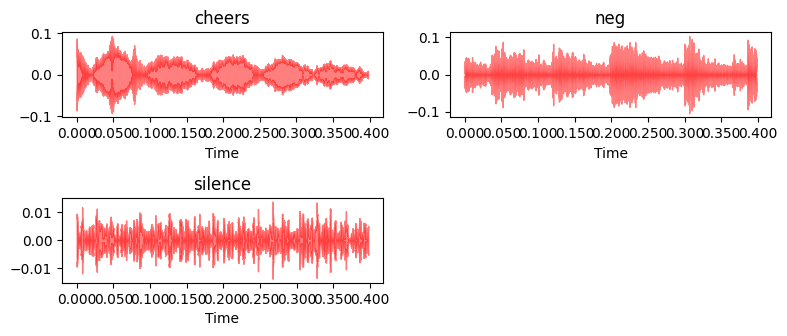

In [15]:
labels = metadata["label"].unique()

fig = plt.figure(figsize=(8,8))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    filtered_df = metadata[metadata["label"] == label]
    slice_file_name = filtered_df["filename"].iloc[0]
    fold = filtered_df["label"].iloc[0]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sr = librosa.load(os.path.join(slice_file_name), sr=SAMPLE_RATE, mono=False)
    librosa.display.waveshow(y = data, sr=sr, color="r", alpha=0.5, label='Harmonic')
    print(slice_file_name)
     
plt.tight_layout()  # This will adjust spacing between subplots to prevent overlap
plt.show() 

In [16]:
# num of channels 
print("Channels: ")
print(metadata.num_channels.value_counts(normalize=True))
print("\n")

# sample rates 
print("Sample Rates: ")
print(metadata.sample_rate.value_counts(normalize=True))
print("\n")

# bit depth
print("Bit Depth: ")
print(metadata.bit_depth.value_counts(normalize=True))
print("\n")

# length in samples
print("Samples: ")
print(metadata.length_in_frames.describe())
print("\n")

# length in seconds
print("Length (s): ")
print(metadata.length_in_seconds.describe())

# RMS
print(metadata.avg_rms.describe())


Channels: 
num_channels
1    1.0
Name: proportion, dtype: float64


Sample Rates: 
sample_rate
44100    1.0
Name: proportion, dtype: float64


Bit Depth: 
bit_depth
16    1.0
Name: proportion, dtype: float64


Samples: 
count     3924.000000
mean     17547.269113
std          6.484944
min      17536.000000
25%      17551.000000
50%      17551.000000
75%      17551.000000
max      17551.000000
Name: length_in_frames, dtype: float64


Length (s): 
count    3924.000000
mean        0.397897
std         0.000147
min         0.397642
25%         0.397982
50%         0.397982
75%         0.397982
max         0.397982
Name: length_in_seconds, dtype: float64
count    3924.000000
mean        0.011955
std         0.009768
min         0.000955
25%         0.005630
50%         0.009086
75%         0.015222
max         0.088642
Name: avg_rms, dtype: float64


## 2.4 Audio Feature Preprocessing:

### Test Main Feature
(Spectrogram , Mel Spectrogram, MFCC)


In [17]:
#!pip install opencv-python

audio_file shape (17551,) - (frames, channels)
audio_file sample rate 44100 Hz
Spectrogram shape (69, 256) - (frames/time, mels/frequency,)
spectrogram min: 0 spectrogram max: 255, average: 100.83854166666667
spectrogram dtype: uint8
audio dtype: float32 - bit depth


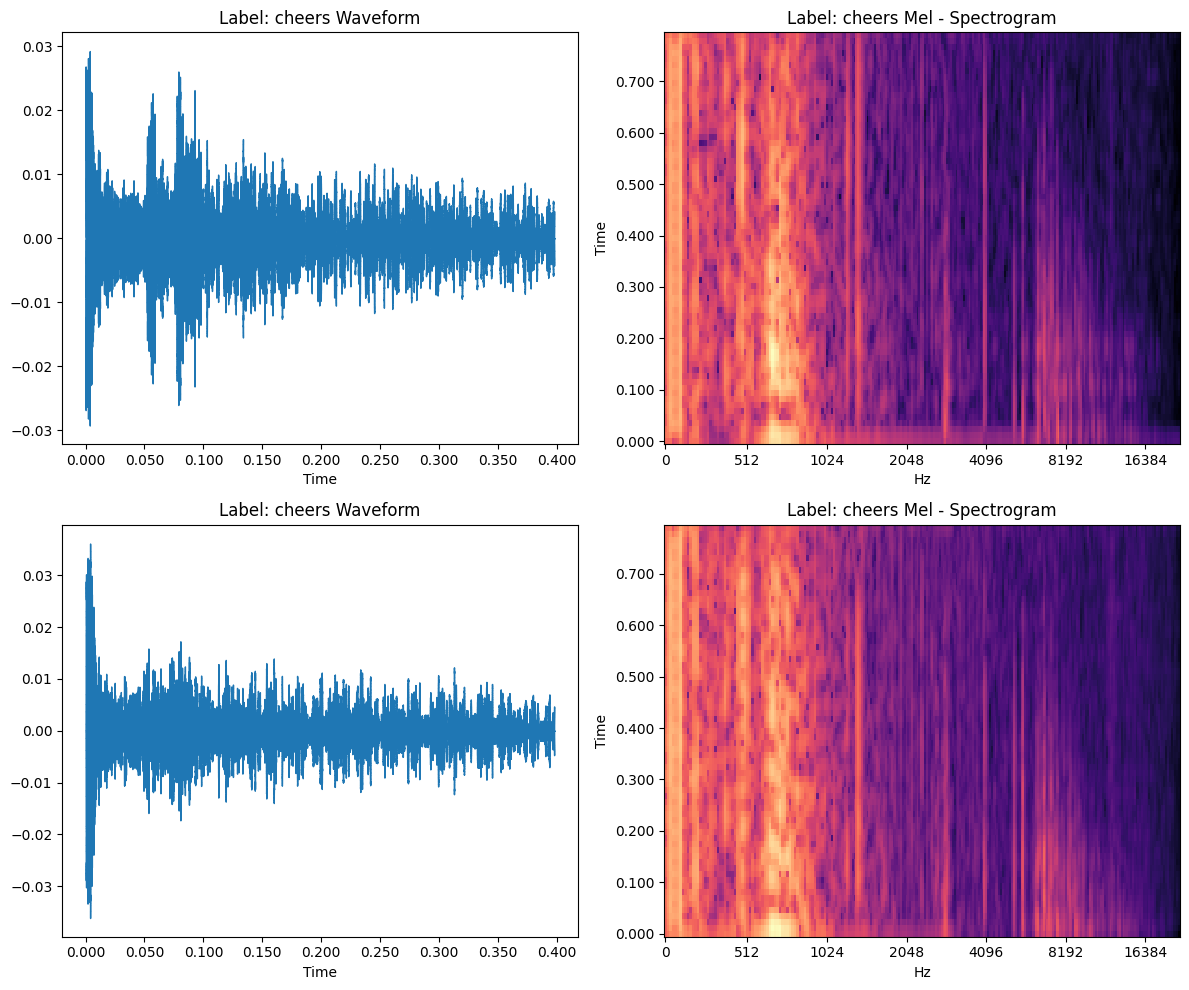

In [18]:
# import cv2
# Test the Fourier transform
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
rows = metadata.iloc[[650, 550]]

#rows = metadata.sample(2)
slice_length = AUDIO_CHUNK
samples_show = len(rows)
pass_ = 0

fig, axes = plt.subplots(nrows=samples_show, ncols=2, figsize=(12, samples_show* 5))

for i, row in rows.iterrows():
    if pass_ > samples_show:
        break
    audio_file, librosa_sample_rate = librosa.load(row["filename"], sr=SAMPLE_RATE)
    if SLICE_AUDIO: 
        print(slice)
        sample_length = slice_length * SAMPLE_RATE

        audio_file = audio_file[:sample_length]
        if len(audio_file) < sample_length:
            audio_file = np.pad(audio_file, (0, sample_length - len(audio_file)), constant_values=0)
    
    if MAIN_FEATURE == 'mfcc':
        # Generate the MFCC
        spectrogram = audio_features.extract_mfcc(y=audio_file)
                # wave Plot
        axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
        librosa.display.waveshow(audio_file, sr=SAMPLE_RATE, ax=axes[pass_, 0])
        # spectrogram plot
        axes[pass_, 1].set_title(f"Label: {row['label']} MFCC")
        img = librosa.display.specshow(spectrogram, sr=SAMPLE_RATE, x_axis='mel', y_axis='time', ax=axes[pass_, 1])
        pass_ += 1


    elif MAIN_FEATURE == 'mel':
        # Generate the mel spectrogram
        spectrogram = audio_features.extract_mel_spectrogram(y=audio_file)
                # wave Plot
        axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
        librosa.display.waveshow(audio_file, sr=SAMPLE_RATE, ax=axes[pass_, 0])
        # spectrogram plot
        axes[pass_, 1].set_title(f"Label: {row['label']} Mel - Spectrogram")
        img = librosa.display.specshow(spectrogram, sr=SAMPLE_RATE, x_axis='mel', y_axis='time', ax=axes[pass_, 1])
        pass_ += 1

        
    elif MAIN_FEATURE == 'stft':
        # Generate the mel spectrogram
        spectrogram = audio_features.extract_spectrogram(y=audio_file)
        #spectrogram = cv2.applyColorMap(spectrogram, cv2.COLORMAP_JET)
                # wave Plot
        axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
        librosa.display.waveshow(audio_file, sr=SAMPLE_RATE, ax=axes[pass_, 0])
        # spectrogram plot
        axes[pass_, 1].set_title(f"Label: {row['label']} Spectrogram")
        img = librosa.display.specshow(spectrogram, sr=SAMPLE_RATE, x_axis='mel', y_axis='time', ax=axes[pass_, 1])
        pass_ += 1

    # Play the audio
    display(Audio(audio_file, rate=SAMPLE_RATE))


print(f"audio_file shape {audio_file.shape} - (frames, channels)")
print(f"audio_file sample rate {SAMPLE_RATE} Hz")
print(f"Spectrogram shape {spectrogram.shape} - (frames/time, mels/frequency,)")
print(f"spectrogram min: {spectrogram.min()} spectrogram max: {spectrogram.max()}, average: {spectrogram.mean()}")
print(f"spectrogram dtype: {spectrogram.dtype}")
print(f"audio dtype: {audio_file.dtype} - bit depth")

#fig.colorbar(img, ax=axes[:, 0], format='%+2.0f dB')
plt.tight_layout()
plt.show()

## 3 Prepare Dataset

## 3.1 Extract features and labels into dataframe

In [19]:
# Preprocessing function

def extract_features(row):
    
    class_label = row["class"]
    
    audio_file,_ = librosa.load(row["filename"], sr=SAMPLE_RATE)

    spectrogram = audio_processor(
        data = audio_file)
    
    shape = spectrogram.shape

    return spectrogram, class_label, shape

In [20]:
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
features = []

for index, row in metadata.iterrows():
    features.append(extract_features(row))
    print(f"Processed {index} file. {row['filename']}")

   
dataset_df = pd.DataFrame(features, columns=["features", "class_label", "shape"])
print('Finished feature extraction from ', len(dataset_df), ' files') 
#N_FRAMES = dataset_df["shape"].iloc[0][0]
#INPUT_SHAPE = (N_FRAMES, dataset_df["shape"].iloc[0][1], NUM_CHANNELS)
print(f"Number of frames: {N_FRAMES}")

Processed 0 file. DATASET\cheers\cheersACwJuray18_0001.wav
Processed 1 file. DATASET\cheers\cheersACwJuray18_0002.wav
Processed 2 file. DATASET\cheers\cheersACwJuray18_0003.wav
Processed 3 file. DATASET\cheers\cheersACwJuray18_0004.wav
Processed 4 file. DATASET\cheers\cheersACwJuray18_0005.wav
Processed 5 file. DATASET\cheers\cheersACwJuray18_0006.wav
Processed 6 file. DATASET\cheers\cheersACwJuray18_0007.wav
Processed 7 file. DATASET\cheers\cheersACwJuray18_0008.wav
Processed 8 file. DATASET\cheers\cheersACwJuray18_0009.wav
Processed 9 file. DATASET\cheers\cheersACwJuray18_0010.wav
Processed 10 file. DATASET\cheers\cheersACwJuray18_0011.wav
Processed 11 file. DATASET\cheers\cheersACwJuray18_0012.wav
Processed 12 file. DATASET\cheers\cheersACwJuray18_0013.wav
Processed 13 file. DATASET\cheers\cheersACwJuray18_0014.wav
Processed 14 file. DATASET\cheers\cheersACwJuray18_0015.wav
Processed 15 file. DATASET\cheers\cheersACwJuray18_0016.wav
Processed 16 file. DATASET\cheers\cheersACwJuray18

### Our feature data stats:

In [21]:
dataset_df.head()

features      class_label  \
0  [[232, 229, 225, 214, 205, 203, 204, 191, 186,...  [1.0, 0.0, 0.0]   
1  [[169, 163, 138, 137, 130, 145, 175, 186, 186,...  [1.0, 0.0, 0.0]   
2  [[209, 206, 204, 199, 195, 196, 203, 196, 192,...  [1.0, 0.0, 0.0]   
3  [[217, 218, 224, 208, 197, 198, 218, 207, 198,...  [1.0, 0.0, 0.0]   
4  [[214, 210, 205, 101, 195, 201, 213, 193, 181,...  [1.0, 0.0, 0.0]   

       shape  
0  (69, 256)  
1  (69, 256)  
2  (69, 256)  
3  (69, 256)  
4  (69, 256)

In [22]:
print(f"Dataset shape: {dataset_df['shape'].value_counts()}")
print(f"Data values Min: {dataset_df['features'].apply(lambda x: x.min()).min()}, Max: {dataset_df['features'].apply(lambda x: x.max()).max()}, dtype: {dataset_df['features'].apply(lambda x: x.dtype).unique()} \nAverage: {dataset_df['features'].apply(lambda x: x.mean()).mean()}, Median: {dataset_df['features'].apply(lambda x: x.mean()).median()}")
print(f"Number of time frames N_FRAMES: {N_FRAMES}")

Dataset shape: shape
(69, 256)    3924
Name: count, dtype: int64
Data values Min: 0, Max: 255, dtype: [dtype('uint8')] 
Average: 99.24469849583204, Median: 97.72282608695652
Number of time frames N_FRAMES: 69


## 3.2 Train Test Split

In [23]:
X = np.array(dataset_df.features.tolist())
y = np.array(dataset_df.class_label.tolist())
X.shape

(3924, 69, 256)

In [24]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)

### Double check prepared dataset

In [25]:
print(f"randomm feature example: {X[0]} and label: {y[0]}")

randomm feature example: [[232 229 225 ...  70  70  69]
 [236 232 224 ...  66  66  65]
 [235 230 215 ...  52  51  50]
 ...
 [211 204 161 ...   6   8   6]
 [204 199 184 ...  12  17  12]
 [192 189 184 ...  15  22  15]] and label: [1. 0. 0.]


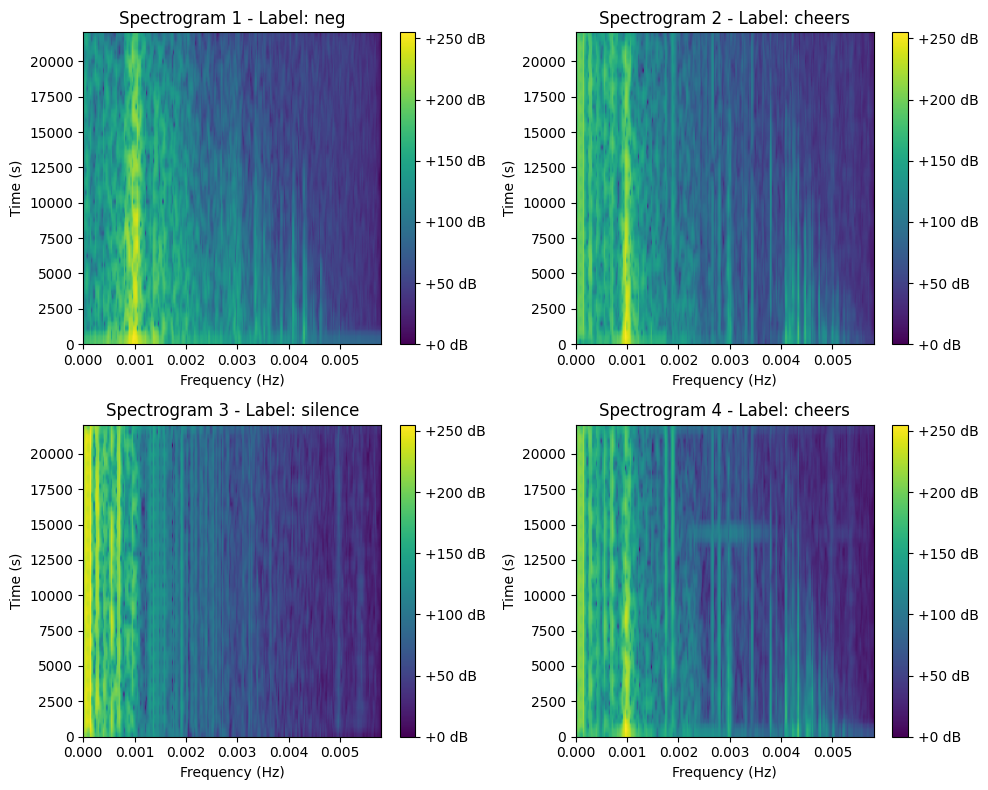

In [26]:
selected_rows = dataset_df.sample(n=4)

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate over the subplots and fill each with a spectrogram
for i, (idx, row) in enumerate(selected_rows.iterrows()):
    spectrogram = row['features']
    label = row['class_label']
    ax = axs[i // 2, i % 2]  # Calculate the subplot position
    im = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis',
                   extent=[0, spectrogram.shape[1] / SAMPLE_RATE, 0, SAMPLE_RATE / 2])
    ax.set_title(f'Spectrogram {i+1} - Label: {idx2label(label, oh_encoder)}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (s)')
    fig.colorbar(im, ax=ax, format='%+2.0f dB')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

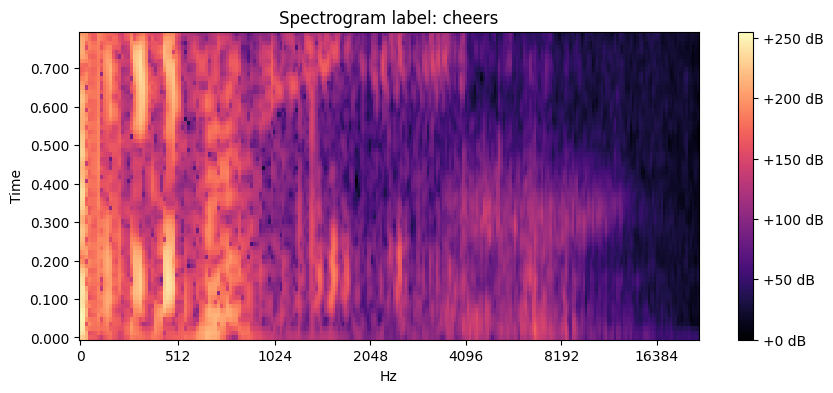

In [27]:
# Get the random feature array
sample_no = 47
sample_f = dataset_df.iloc[sample_no]["features"]
sample_l = dataset_df.iloc[sample_no]["class_label"]
# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_f, sr=SAMPLE_RATE, x_axis='mel', y_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram label: ' + idx2label(sample_l, oh_encoder))
plt.show()

## 3.3 Reshape sets for NN input layer

In [28]:
#x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[])
#x_test = x_test.reshape((x_test.shape[0],) + INPUT_SHAPE)

num_labels = y.shape[1]
print(f"num_labels: {num_labels}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

num_labels: 3
x_train shape: (3139, 69, 256)
y_train shape: (3139, 3)


# 4. Build Deep Learning Model

## 4.1 Load deep neural net

In [29]:
# load a class with various model archietectures to test
modelClass = Deep_NN(num_classes=num_labels, input_shape=INPUT_SHAPE)

In [30]:
# Choose model architecture to train on
# MODEL_ARCH = customCNN1 mobilenetv3_nn convnext_nn effnetv2_nn dense_nn
# MODEL_TYPE = small large tiny base (optional)
#MODEL_ARCH = "dense_nn"
#MODEL_TYPE = "small"

model = getattr(modelClass, MODEL_ARCH)(type=MODEL_TYPE)

#model = modelClass.defaultCNN()

Active Neural Net: 'defaultCNN' default, 
 Input Shape: (69, 256, 1) 
 Num Classes: 3 



## 4.2 Compile Sequential Model

In [31]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [32]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=optimizer, 
    loss='CategoricalCrossentropy', 
    metrics=['accuracy', Precision(), Recall()]
    )

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 254, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 252, 16)       2320      
                                                                 
 flatten (Flatten)           (None, 262080)            0         
                                                                 
 dense (Dense)               (None, 128)               33546368  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 33,549,235
Trainable params: 33,549,235
Non-trainable params: 0
_________________________________________________________________


## 4.3 Fit Model, View Loss and KPI Plots

In [34]:
hist = model.fit(x_train, 
                 y_train, 
                 epochs=EPOCHS, 
                 validation_data=(x_test, y_test), 
                 batch_size=BATCH_SIZE
                 )

Epoch 1/20
393/393 [==============================] - 66s 167ms/step - loss: 10.1903 - accuracy: 0.9802 - precision: 0.9805 - recall: 0.9796 - val_loss: 0.0516 - val_accuracy: 0.9924 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 2/20
393/393 [==============================] - 68s 172ms/step - loss: 3.7235e-04 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9997 - val_loss: 0.0510 - val_accuracy: 0.9924 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 3/20
393/393 [==============================] - 69s 176ms/step - loss: 6.8509e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0470 - val_accuracy: 0.9936 - val_precision: 0.9949 - val_recall: 0.9936
Epoch 4/20
393/393 [==============================] - 67s 170ms/step - loss: 1.7524e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0471 - val_accuracy: 0.9936 - val_precision: 0.9949 - val_recall: 0.9936
Epoch 5/20
393/393 [==============================] - 70s 178ms/step - loss: 1.

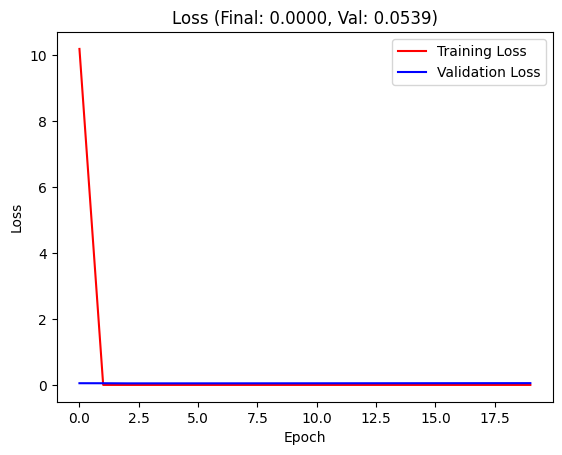

In [35]:
# Extract the final loss and accuracy values
final_loss = hist.history['loss'][-1]
final_val_loss = hist.history['val_loss'][-1]

# Plot loss
plt.figure()
plt.title(f'Loss (Final: {final_loss:.4f}, Val: {final_val_loss:.4f})')
plt.plot(hist.history['loss'], 'r', label='Training Loss')
plt.plot(hist.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.savefig(os.path.join(PLOTS_DIR, f'loss-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.png'))
plt.show()

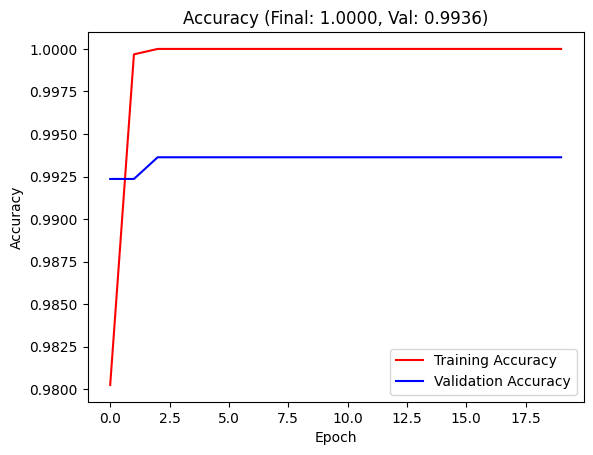

In [36]:
final_accuracy = hist.history['accuracy'][-1]
final_val_accuracy = hist.history['val_accuracy'][-1]

plt.figure()
plt.title(f'Accuracy (Final: {final_accuracy:.4f}, Val: {final_val_accuracy:.4f})')
plt.plot(hist.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig(os.path.join(PLOTS_DIR, f'accuracy-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.png'))
plt.show()

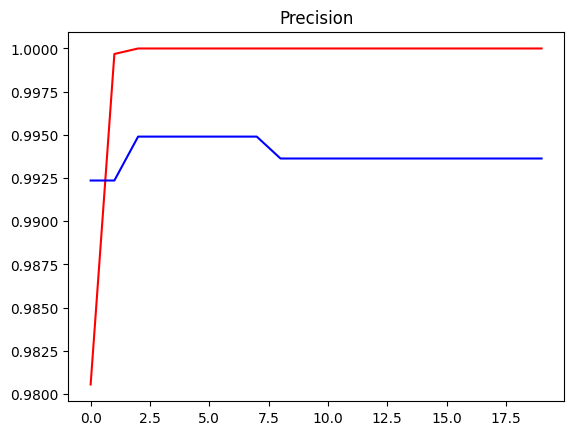

In [37]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

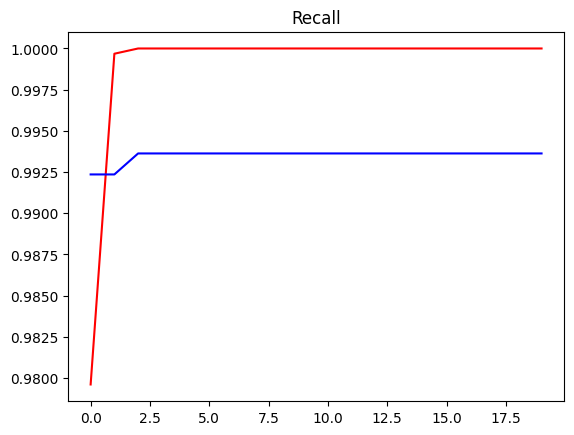

In [38]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 5. Taining Evaluation

## 5.1 Make a Prediction, Plot performance

In [39]:
predictions = model.predict(x_test)

25/25 [==============================] - 2s 77ms/step


In [40]:
print(idx2label(predictions[19], oh_encoder))
print(idx2label(y_test[19], oh_encoder))
print(f"input default shape: {x_test[1].shape}")
print(f"reshaped input feature shape: {np.expand_dims((x_test[21]), axis=0).shape}")

neg
neg
input default shape: (69, 256)
reshaped input feature shape: (1, 69, 256)


In [41]:
prediction = model.predict(np.expand_dims((x_test[1]), axis=0))
print(prediction)
print(idx2label(prediction, oh_encoder))

1/1 [==============================] - 0s 44ms/step
[[1. 0. 0.]]
cheers


In [42]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

99/99 [==============================] - 7s 72ms/step - loss: 2.8862e-08 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000
Training Accuracy:  1.0
25/25 [==============================] - 2s 71ms/step - loss: 0.0539 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936
Testing Accuracy:  0.993630588054657


25/25 [==============================] - 2s 71ms/step - loss: 0.0539 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936


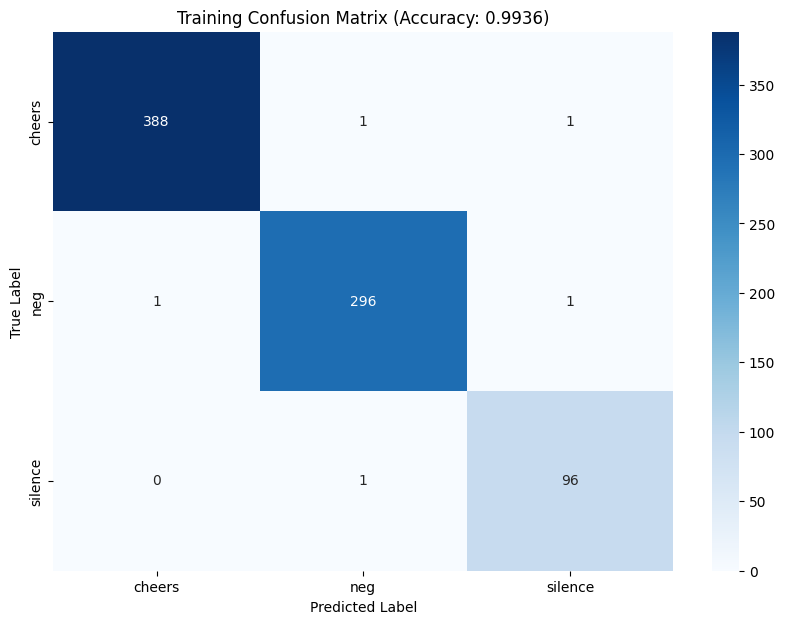

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Assuming 'predictions' is an array of predicted probabilities for each class
# And 'y_test' is an array of actual class labels

# Convert predicted probabilities to class labels
predicted_labels = [idx2label(pred, oh_encoder) for pred in predictions]
y_test_labels = [idx2label(pred, oh_encoder) for pred in y_test]

# Use LabelEncoder to handle class names
label_encoder = LabelEncoder()
label_encoder.fit(y_test_labels + predicted_labels)  # Fit encoder on both true and predicted labels

# Transform labels to numeric values
y_test_numeric = label_encoder.transform(y_test_labels)
predictions_numeric = label_encoder.transform(predicted_labels)

# Create the confusion matrix with real label names
cm = confusion_matrix(y_test_numeric, predictions_numeric)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

score = model.evaluate(x_test, y_test, verbose=1)
plt.title(f"Training Confusion Matrix (Accuracy: {score[1]:.4f})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig(os.path.join(PLOTS_DIR, f"confusion_matrix-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.png"))

plt.show()

## 5.2 Save Model

In [44]:
model.save(f"{MODEL_PATH}.keras")
joblib.dump(oh_encoder, LABELER_PATH)

['MODEL\\labeler-test01-defaultCNN-default-mel.joblib']

## 5.3 Save for TF-lite

In [45]:
model.save(MODEL_PATH, save_format='tf')

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: apply optimizations for quantization
tflite_model = converter.convert()
with open(LITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: MODEL\model-test01-defaultCNN-default-mel\assets


INFO:tensorflow:Assets written to: MODEL\model-test01-defaultCNN-default-mel\assets


In [ ]:
import json
config = {
        "audio_chunk": AUDIO_CHUNK,
        "data_range": DATA_RANGE,
        "num_channels": NUM_CHANNELS,
        "sample_rate": SAMPLE_RATE,

        "num_mels": N_MELS,
        "n_fft": NFFT,
        "hop_length": HOP_LENGTH,
        "n_frames": N_FRAMES,
        "n_mfcc": N_MFCC,
        "fmax": FMAX
    }

CONFIG_PATH = os.path.join("model", "config.json")
with open(CONFIG_PATH, 'w') as config_file:
    json.dump(config, config_file, indent=4)

# 6. Inference 

### Load local model and labels

In [46]:
# Load the encoder in the inference environment
loaded_encoder = joblib.load(LABELER_PATH)
model = tf.keras.models.load_model(f"{MODEL_PATH}.keras")

## 6.1 Inference on local files and loaded model

### 6.1.1 Confusion Matrix for TEST_DIR

1/1 [==============================] - 0s 33ms/step


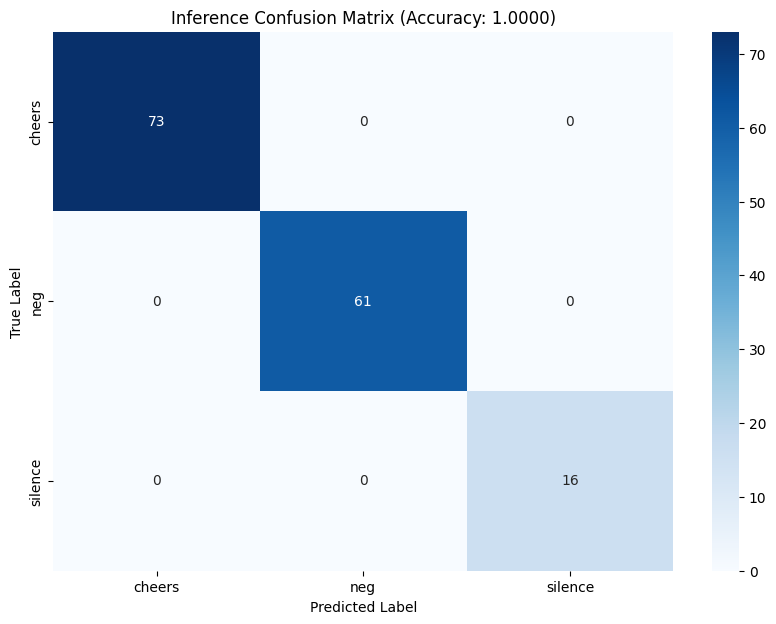

In [47]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import librosa
from sklearn.preprocessing import LabelEncoder


NUM_FILES_TO_TEST = 150  # Specify the number of files to test



# Get all audio files and corresponding labels from the TEST_DIR
audio_files = []
labels = []
for root, _, files in os.walk(TEST_DIR):
    for file in files:
        if file.endswith(('.wav', '.mp3')):  # Add other audio file extensions if needed
            audio_files.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Ensure there are files to process
if not audio_files:
    print("No files in test directory")
    exit()

# Shuffle and select a subset of files
if len(audio_files) < NUM_FILES_TO_TEST:
    print(f"Only {len(audio_files)} files available. Testing all available files.")
    selected_files = audio_files
    selected_labels = labels
else:
    selected_indices = random.sample(range(len(audio_files)), NUM_FILES_TO_TEST)
    selected_files = [audio_files[i] for i in selected_indices]
    selected_labels = [labels[i] for i in selected_indices]

# Filter out labels not present in the encoder
encoder_classes = set(loaded_encoder.categories_[0])
filtered_files_labels = [(file, label) for file, label in zip(selected_files, selected_labels) if label in encoder_classes]

if not filtered_files_labels:
    print("No valid labels in selected files")
    exit()

selected_files, selected_labels = zip(*filtered_files_labels)

# Process all files and collect predictions and true labels
predictions = []
y_test_labels = []
for file, label in zip(selected_files, selected_labels):
    data, _ = librosa.load(file, sr=SAMPLE_RATE)
    prediction_feature = audio_processor(data=data)
    prediction_feature = np.expand_dims(prediction_feature, axis=0)
    predicted_class = model.predict(prediction_feature)
    predicted_label = idx2label(predicted_class, loaded_encoder)
    
    predictions.append(predicted_label)
    y_test_labels.append(label)

# Use LabelEncoder for label transformation
label_encoder = LabelEncoder()
label_encoder.fit(list(encoder_classes))  # Fit encoder on known classes

# Transform labels to numeric values
y_test_numeric = label_encoder.transform(y_test_labels)
predictions_numeric = label_encoder.transform(predictions)

# Create the confusion matrix with real label names
cm = confusion_matrix(y_test_numeric, predictions_numeric)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

accuracy = np.mean([1 if p == t else 0 for p, t in zip(predictions, y_test_labels)])
plt.title(f"Inference Confusion Matrix (Accuracy: {accuracy:.4f})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save the figure
plt.savefig(os.path.join(PLOTS_DIR, f"INFERENCE-confusion_matrix-{NEW_MODEL_NAME}-{MODEL_ARCH}-{MODEL_TYPE}-{MAIN_FEATURE}.png"))

# Show the plot
plt.show()


### 6.1.2 Closer Inspection with Listen

In [48]:
import os
import random
import time
from IPython.display import Audio, display
import librosa

NUM_FILES_TO_TEST = 25  # Specify the number of files to test


# Check if 'selected_files' and 'selected_labels' are available from the confusion matrix cell
try:
    selected_files
    selected_labels
    print("Using previously selected files from the confusion matrix cell.")
except NameError:
    # If not available, proceed with random selection
    audio_files = []
    labels = []
    for root, _, files in os.walk(TEST_DIR):
        for file in files:
            if file.endswith(('.wav', '.mp3')):  # Add other audio file extensions if needed
                audio_files.append(os.path.join(root, file))
                labels.append(os.path.basename(root))

    if len(audio_files) < NUM_FILES_TO_TEST:
        print(f"Only {len(audio_files)} files available. Testing all available files.")
        selected_files = audio_files
        selected_labels = labels
    else:
        selected_indices = random.sample(range(len(audio_files)), NUM_FILES_TO_TEST)
        selected_files = [audio_files[i] for i in selected_indices]
        selected_labels = [labels[i] for i in selected_indices]
    print("Randomly selected new files for testing.")

# Ensure there are files to process
if not selected_files:
    print("No files in test directory")
    exit()

# Process and predict each file, then play the audio and display the prediction
for file, label in zip(selected_files, selected_labels):
    path = file
    print("Playing file:", os.path.basename(file))
    data, _ = librosa.load(path, sr=SAMPLE_RATE)
    
    prediction_feature = audio_processor(data=data)
    
    # Reshape to match model input shape
    prediction_feature = prediction_feature.reshape(1, N_FRAMES, N_MELS, NUM_CHANNELS)
    predicted_class = model.predict(prediction_feature)
    predicted_label = idx2label(predicted_class, loaded_encoder)
    
    # Play the audio
    display(Audio(data, rate=SAMPLE_RATE))
    
    # Display the predicted class
    print("The predicted class is:", predicted_label, '\n')
    
    #time.sleep(0.1)


Using previously selected files from the confusion matrix cell.
Playing file: cuttlerywJuray9_0444.wav
1/1 [==============================] - 0s 91ms/step


The predicted class is: neg 

Playing file: cheerswJuray2_0073.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: cheers 

Playing file: cheerswAmb2_0080.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: cheers 

Playing file: ambient_0017.wav
1/1 [==============================] - 0s 44ms/step


The predicted class is: silence 

Playing file: cheerswJuray4_0226.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0240.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: neg 

Playing file: cuttlerywac7_0371.wav
1/1 [==============================] - 0s 34ms/step


The predicted class is: neg 

Playing file: zasedacka_AC_ambient_0151.wav
1/1 [==============================] - 0s 47ms/step


The predicted class is: silence 

Playing file: cuttlerywac7_0320.wav
1/1 [==============================] - 0s 40ms/step


The predicted class is: neg 

Playing file: zasedacka_AC_ambient_0081.wav
1/1 [==============================] - 0s 38ms/step


The predicted class is: silence 

Playing file: cheersACwJuray18_0459.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0147.wav
1/1 [==============================] - 0s 28ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0140.wav
1/1 [==============================] - 0s 50ms/step


The predicted class is: neg 

Playing file: cheerswJuray3_0054.wav
1/1 [==============================] - 0s 51ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0151.wav
1/1 [==============================] - 0s 135ms/step


The predicted class is: neg 

Playing file: cheerswAmb1_0143.wav
1/1 [==============================] - 0s 45ms/step


The predicted class is: cheers 

Playing file: cheerswJuray5_0034.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: cheers 

Playing file: cheerswJuray4_0143.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0203.wav
1/1 [==============================] - 0s 34ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0246.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: neg 

Playing file: cheerswAmb3_0028.wav
1/1 [==============================] - 0s 43ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0110.wav
1/1 [==============================] - 0s 33ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0349.wav
1/1 [==============================] - 0s 43ms/step


The predicted class is: neg 

Playing file: cheerswAmb3_0029.wav
1/1 [==============================] - 0s 63ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0166.wav
1/1 [==============================] - 0s 44ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0138.wav
1/1 [==============================] - 0s 50ms/step


The predicted class is: cheers 

Playing file: zasedacka_AC_ambient_0064.wav
1/1 [==============================] - 0s 26ms/step


The predicted class is: silence 

Playing file: cheersACwJuray18_0201.wav
1/1 [==============================] - 0s 48ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0215.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: neg 

Playing file: cuttlerywac7_0244.wav
1/1 [==============================] - 0s 30ms/step


The predicted class is: neg 

Playing file: cheersACwJuray18_0251.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0158.wav
1/1 [==============================] - 0s 25ms/step


The predicted class is: cheers 

Playing file: cheerswJuray1_0122.wav
1/1 [==============================] - 0s 28ms/step


The predicted class is: cheers 

Playing file: cheersACwJuray18_0482.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0288.wav
1/1 [==============================] - 0s 39ms/step


The predicted class is: neg 

Playing file: dishesCuttlery600_0054.wav
1/1 [==============================] - 0s 32ms/step


The predicted class is: neg 

Playing file: cheerswJuray1_0228.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0458.wav
1/1 [==============================] - 0s 50ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0199.wav
1/1 [==============================] - 0s 32ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0327.wav
1/1 [==============================] - 0s 38ms/step


The predicted class is: neg 

Playing file: dishesCuttlery600_0405.wav
1/1 [==============================] - 0s 48ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0162.wav
1/1 [==============================] - 0s 26ms/step


The predicted class is: neg 

Playing file: cuttlerywac7_0484.wav
1/1 [==============================] - 0s 46ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0080.wav
1/1 [==============================] - 0s 53ms/step


The predicted class is: neg 

Playing file: cheerswJuray5_0016.wav
1/1 [==============================] - 0s 56ms/step


The predicted class is: cheers 

Playing file: cheerswJuray3_0049.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: cheers 

Playing file: zasedacka_AC_only_0063.wav
1/1 [==============================] - 0s 37ms/step


The predicted class is: silence 

Playing file: cuttlerywJuray9_0458.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: neg 

Playing file: zasedacka_AC_ambient_0129.wav
1/1 [==============================] - 0s 43ms/step


The predicted class is: silence 

Playing file: cheerswJuray4_0438.wav
1/1 [==============================] - 0s 34ms/step


The predicted class is: cheers 

Playing file: zasedacka_AC_ambient_0061.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: silence 

Playing file: zasedacka_AC_ambient_0109.wav
1/1 [==============================] - 0s 43ms/step


The predicted class is: silence 

Playing file: cheerswJuray2_0077.wav
1/1 [==============================] - 0s 184ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0228.wav
1/1 [==============================] - 0s 51ms/step


The predicted class is: neg 

Playing file: cheerswJuray1_0146.wav
1/1 [==============================] - 0s 39ms/step


The predicted class is: cheers 

Playing file: cheerswJuray4_0106.wav
1/1 [==============================] - 0s 46ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0051.wav
1/1 [==============================] - 0s 51ms/step


The predicted class is: neg 

Playing file: dishesCuttlery600_0359.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: neg 

Playing file: zasedacka_AC_ambient_0047.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: silence 

Playing file: dishesCuttlery600_0094.wav
1/1 [==============================] - 0s 43ms/step


The predicted class is: neg 

Playing file: cheersACwJuray18_0126.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0115.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0171.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: cheers 

Playing file: cheerswJuray4_0038.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: cheers 

Playing file: cheerswAmb3_0067.wav
1/1 [==============================] - 0s 26ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0268.wav
1/1 [==============================] - 0s 58ms/step


The predicted class is: neg 

Playing file: ambient_0069.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: silence 

Playing file: cheerswJuray5_0146.wav
1/1 [==============================] - 0s 43ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0200.wav
1/1 [==============================] - 0s 51ms/step


The predicted class is: neg 

Playing file: zasedacka_AC_ambient_0007.wav
1/1 [==============================] - 0s 46ms/step


The predicted class is: silence 

Playing file: cheerswAmb1_0068.wav
1/1 [==============================] - 0s 52ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0296.wav
1/1 [==============================] - 0s 54ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0170.wav
1/1 [==============================] - 0s 40ms/step


The predicted class is: neg 

Playing file: cuttlerywac7_0295.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: neg 

Playing file: cheerswJuray4_0366.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0146.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: neg 

Playing file: cheersACwJuray18_0465.wav
1/1 [==============================] - 0s 48ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0006.wav
1/1 [==============================] - 0s 31ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0313.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: neg 

Playing file: cheerswJuray1_0098.wav
1/1 [==============================] - 0s 224ms/step


The predicted class is: cheers 

Playing file: zasedacka_AC_only_0201.wav
1/1 [==============================] - 0s 51ms/step


The predicted class is: silence 

Playing file: zasedacka_AC_ambient_0003.wav
1/1 [==============================] - 0s 54ms/step


The predicted class is: silence 

Playing file: dishesCuttlery600_0187.wav
1/1 [==============================] - 0s 233ms/step


The predicted class is: neg 

Playing file: dishesCuttlery600_0053.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: neg 

Playing file: cheersACwJuray18_0409.wav
1/1 [==============================] - 0s 45ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0073.wav
1/1 [==============================] - 0s 228ms/step


The predicted class is: cheers 

Playing file: cheerswJuray4_0203.wav
1/1 [==============================] - 0s 30ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0112.wav
1/1 [==============================] - 0s 53ms/step


The predicted class is: neg 

Playing file: cheerswAmb1_0135.wav
1/1 [==============================] - 0s 92ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0076.wav
1/1 [==============================] - 0s 33ms/step


The predicted class is: neg 

Playing file: cheersACwJuray18_0193.wav
1/1 [==============================] - 0s 50ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0087.wav
1/1 [==============================] - 0s 46ms/step


The predicted class is: cheers 

Playing file: cheerswJuray5_0053.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0191.wav
1/1 [==============================] - 0s 150ms/step


The predicted class is: neg 

Playing file: cheerswJuray5_0023.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0012.wav
1/1 [==============================] - 0s 48ms/step


The predicted class is: neg 

Playing file: cheerswJuray4_0146.wav
1/1 [==============================] - 0s 39ms/step


The predicted class is: cheers 

Playing file: cheerswAmb3_0011.wav
1/1 [==============================] - 0s 39ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0321.wav
1/1 [==============================] - 0s 32ms/step


The predicted class is: neg 

Playing file: cheerswJuray2_0033.wav
1/1 [==============================] - 0s 39ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0339.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: neg 

Playing file: cheerswJuray4_0331.wav
1/1 [==============================] - 0s 40ms/step


The predicted class is: cheers 

Playing file: cheerswJuray1_0136.wav
1/1 [==============================] - 0s 27ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0483.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: neg 

Playing file: cheerswJuray4_0260.wav
1/1 [==============================] - 0s 47ms/step


The predicted class is: cheers 

Playing file: cheerswJuray4_0321.wav
1/1 [==============================] - 0s 34ms/step


The predicted class is: cheers 

Playing file: cheerswAmb3_0050.wav
1/1 [==============================] - 0s 48ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0186.wav
1/1 [==============================] - 0s 38ms/step


The predicted class is: cheers 

Playing file: cheerswJuray1_0101.wav
1/1 [==============================] - 0s 32ms/step


The predicted class is: cheers 

Playing file: cheersACwJuray18_0245.wav
1/1 [==============================] - 0s 33ms/step


The predicted class is: cheers 

Playing file: cheerswJuray5_0143.wav
1/1 [==============================] - 0s 52ms/step


The predicted class is: cheers 

Playing file: cheerswJuray5_0015.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0091.wav
1/1 [==============================] - 0s 50ms/step


The predicted class is: neg 

Playing file: dishesCuttlery600_0387.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0427.wav
1/1 [==============================] - 0s 50ms/step


The predicted class is: neg 

Playing file: zasedacka_AC_only_0005.wav
1/1 [==============================] - 0s 39ms/step


The predicted class is: silence 

Playing file: cheerswJuray5_0088.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: cheers 

Playing file: cheersACwJuray18_0299.wav
1/1 [==============================] - 0s 45ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0068.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: neg 

Playing file: cheerswJuray4_0039.wav
1/1 [==============================] - 0s 31ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0010.wav
1/1 [==============================] - 0s 39ms/step


The predicted class is: neg 

Playing file: cuttlerywac7_0014.wav
1/1 [==============================] - 0s 45ms/step


The predicted class is: neg 

Playing file: cheerswJuray4_0006.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: cheers 

Playing file: cheersACwJuray18_0339.wav
1/1 [==============================] - 0s 42ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0381.wav
1/1 [==============================] - 0s 44ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0129.wav
1/1 [==============================] - 0s 41ms/step


The predicted class is: neg 

Playing file: cheerswJuray5_0117.wav
1/1 [==============================] - 0s 38ms/step


The predicted class is: cheers 

Playing file: cuttlerywJuray9_0448.wav
1/1 [==============================] - 0s 54ms/step


The predicted class is: neg 

Playing file: dishesCuttlery600_0004.wav
1/1 [==============================] - 0s 35ms/step


The predicted class is: neg 

Playing file: dishesCuttlery600_0315.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0388.wav
1/1 [==============================] - 0s 49ms/step


The predicted class is: neg 

Playing file: dishesCuttlery600_0449.wav
1/1 [==============================] - 0s 25ms/step


The predicted class is: neg 

Playing file: cuttlerywac7_0003.wav
1/1 [==============================] - 0s 34ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0449.wav
1/1 [==============================] - 0s 48ms/step


The predicted class is: neg 

Playing file: cheerswJuray4_0238.wav
1/1 [==============================] - 0s 54ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0078.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: cheers 

Playing file: zasedacka_AC_only_0039.wav
1/1 [==============================] - 0s 34ms/step


The predicted class is: silence 

Playing file: zasedacka_AC_ambient_0176.wav
1/1 [==============================] - 0s 44ms/step


The predicted class is: silence 

Playing file: cuttlerywJuray9_0188.wav
1/1 [==============================] - 0s 47ms/step


The predicted class is: neg 

Playing file: cheerswJuray5_0105.wav
1/1 [==============================] - 0s 43ms/step


The predicted class is: cheers 

Playing file: cheerswAmb1_0132.wav
1/1 [==============================] - 0s 22ms/step


The predicted class is: cheers 

Playing file: cheerswJuray1_0114.wav
1/1 [==============================] - 0s 36ms/step


The predicted class is: cheers 

Playing file: cheerswJuray4_0301.wav
1/1 [==============================] - 0s 47ms/step


The predicted class is: cheers 

Playing file: cheerswJuray5_0149.wav
1/1 [==============================] - 0s 40ms/step


The predicted class is: cheers 

Playing file: dishesCuttlery600_0324.wav
1/1 [==============================] - 0s 322ms/step


The predicted class is: neg 

Playing file: cheerswJuray4_0308.wav
1/1 [==============================] - 0s 44ms/step


The predicted class is: cheers 

Playing file: cuttlerywac7_0462.wav
1/1 [==============================] - 0s 117ms/step


The predicted class is: neg 

Playing file: cuttlerywJuray9_0077.wav
1/1 [==============================] - 0s 65ms/step


The predicted class is: neg 

Playing file: cheerswJuray5_0168.wav
1/1 [==============================] - 0s 43ms/step


The predicted class is: cheers 

Playing file: cheerswJuray1_0155.wav
1/1 [==============================] - 0s 53ms/step


The predicted class is: cheers 



## 6.2 Real-time inference

## run "run.py"

In [49]:
from inference_class import SoundClassificationService

def main():

    config = {
        "model_path": MODEL_PATH,
        "labels_path": LABELER_PATH,
        
        "sample_rate": SAMPLE_RATE,
        "num_channels": NUM_CHANNELS,
        "audio_chunk": AUDIO_CHUNK,
        
        "num_mels": N_MELS,
        "n_fft": NFFT,
        "fmax": FMAX,
        "hop_length": HOP_LENGTH,
        
        "confidence_threshold": 0.8,
        "listening_hop_length": 0.5,
        "device": "cpu",
        "data_range": DATA_RANGE
        

    }

    service = SoundClassificationService.get_instance(config)
    service.listen_and_predict(duration=AUDIO_CHUNK)


if __name__ == "__main__":
    main()

1


KeyError: 'main_feature'